In [19]:
import json
import csv
import os
from itertools import islice

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#import lib.BasicMeasurement as basic
#import lib.ResolverMeasurement as by_ns

## Extracting IPs (obsolete)

This notebook works on the hierarchical combined data structure.

It is used for the following purposes:

- extract egress IPs
- process extracted IPs to find overlap / shared egress IPs

In [7]:

# Working directory
dataset_dir = "public1000-2/"

# Data Source
db_path = dataset_dir + "combined/enum/data/"
# File suffix filter
pattern_suffix = ""

Read from database / combined data folder and extract egress IPs into an aggregate json file.

Format:

```json
    {
        "ns": "8.8.8.8",
        "unique_egress": 3,
        "egress_ips": ["list of unique egress ips overall"],
        "vps": {
            "1.2.3.4": ["list of egress ips"]
        }
    }
```

In [8]:

# Output file
egress_ip_file = dataset_dir + "egress.json"



In [9]:
with open(egress_ip_file, 'w') as of: # open outfile
  
  # Walk database directory 
  for root, dirs, files in os.walk(db_path):
    for file in files:
      
      # Skip files that are not of the pattern we want
      if not file.endswith(pattern_suffix): 
        continue
      fn = os.path.join(root, file)

      with open(fn, 'r') as f: # open nameserver file

        # Read, parse, filter data 
        data = []
        try:
          data = [basic.BasicMeasurement(json.loads(l)) for l in f if l != "\n"]
        except json.decoder.JSONDecodeError:
          print("Error parsing file: " + fn)
          exit(1)
          
        data = [d for d in data if d.has_logentries()]
        if len(data) == 0:
          continue

        ns = by_ns.NameserverMeasurement(data, data[0].get_nameserver())

        # Prepare output
        vps = dict()
        for v in ns.get_vantagepoints():
          vps[v] = ns.get_unique_egress_ips(v)
        
        r = {
          "ns": ns.get_nameserver(),
          "unique_egress": len(ns.get_unique_egress_ips()),
          "egress_ips": ns.get_unique_egress_ips(),
          "vps":  vps
        }
        # Write to output file
        of.write(json.dumps(r) + "\n")


## Computing Overlap

Take the aggregate json file and create a csv file for pairs of ns that share egress IPs.

Format:

```csv
ns0,ns1,vp0,num_common_egress_ips,num_total_unique,percent_overlap
```

This file can be used as an input to measurement patterns that require two nameservers.

In [24]:
# Input file
egress_ip_file = dataset_dir + "egress.json"

# Output file
shared_egress_file = dataset_dir + "egress_overlap.csv"

In [2]:
egress_ip_file = 'agg600k1vp/egress.json'

In [3]:
ingress_map = dict()
egress_map = dict()

with open(egress_ip_file, 'r') as f: # open infile

  # Read, parse, filter data 
  for l in f:
    data = json.loads(l)
    egress = set(data["egress_ips"])
    ingress_map[data["ns"]] = egress
    for e in egress:
      if e not in egress_map:
        egress_map[e] = set()
      egress_map[e].add(data["ns"])


In [5]:
print("Ingress map: ", len(ingress_map))
print("Egress map: ", len(egress_map))

Ingress map:  626282
Egress map:  78580


In [6]:

print(f"Intersection of keys: {len(ingress_map.keys() & egress_map.keys())}")

Intersection of keys: 26882


In [35]:
m = max([len(ing) for ing in egress_map.values()])
print(f"Maximum Number of Ingress: {m}")

Maximum Number of Ingress: 624158


In [11]:
egress = sorted(egress_map.keys(), key = lambda x: tuple(map(int, x.split('.'))))

In [5]:
num_ingress = [len(egress_map[e]) for e in egress]

Text(0.5, 1.0, 'Number of Ingress IPs per Egress IP')

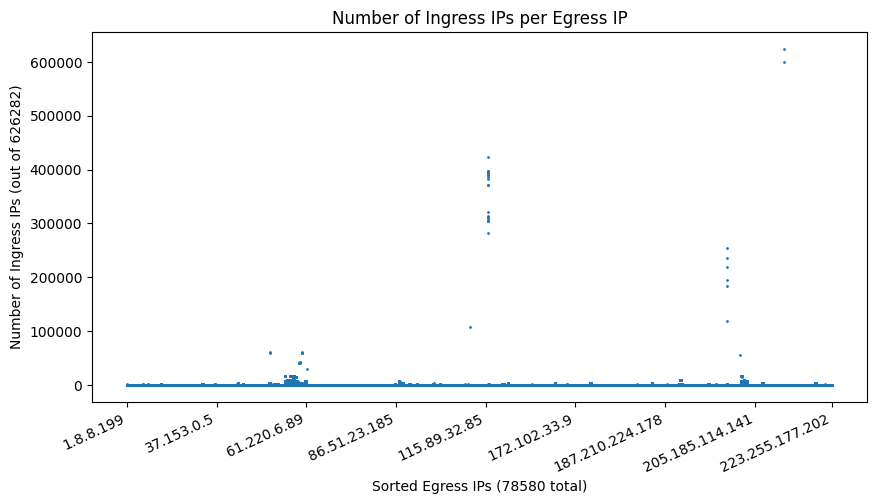

In [51]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
# Incrementing integers of length egress
x = np.arange(len(egress)).astype(int)

ax.scatter(x, num_ingress, s=1)
#ax.set_yscale('log')
#ax.set_ylim(10, 1000000)
#ax.set_ylim(0, 1000)

# Set string ticks for every 10000th sample
#formatter = ticker.FuncFormatter(lambda x, _: egress[x])
#ax.xaxis.set_major_formatter(formatter)
#ax.xaxis.set_major_locator(ticker.MaxNLocator(5))

ticks = egress[::10000] + [egress[-1]]
ax.set_xticks([x[i] for i in range(0, len(egress), 10000)] + [x[-1]])
ax.set_xticklabels(ticks, rotation=25, ha='right')

ax.set_xlabel(f'Sorted Egress IPs ({len(egress)} total)')
ax.set_ylabel(f'Number of Ingress IPs (out of {len(ingress_map)})')
ax.set_title('Number of Ingress IPs per Egress IP')

In [54]:
num_mask = np.array(num_ingress) > 500000
print(np.sum(num_mask))
print(np.array(egress, dtype=str)[num_mask])

2
['211.229.63.141' '211.229.63.142']


Text(0.5, 1.0, 'CDF of Number of Ingress IPs per Egress IP')

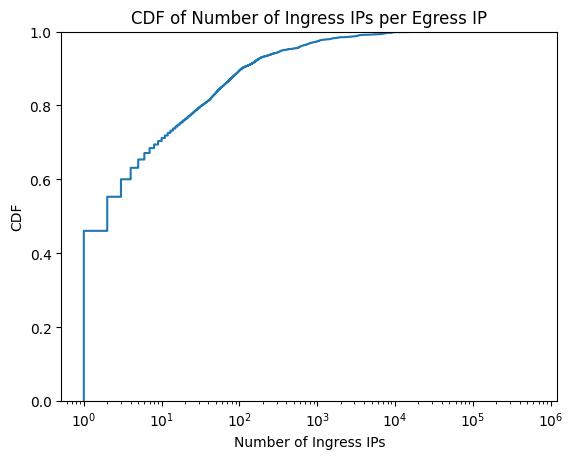

In [50]:

fig, ax = plt.subplots()
ax.ecdf(num_ingress)
ax.set_xscale('log')
ax.set_xlabel('Number of Ingress IPs')
ax.set_ylabel('CDF')
ax.set_title('CDF of Number of Ingress IPs per Egress IP')

Text(0, 0.5, 'Frequency')

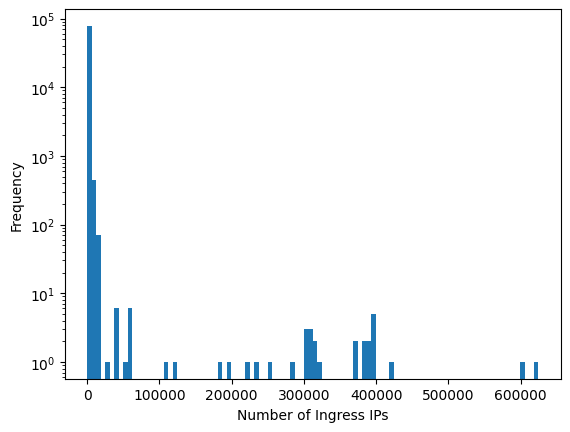

In [49]:
fig, ax = plt.subplots()
ax.hist(num_ingress, bins=100, log=True)
#ax.set_xscale('log')
ax.set_xlabel('Number of Ingress IPs')
ax.set_ylabel('Frequency')